In [2]:
import pandas as pd
import numpy as np
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.components.metrics import get_time_dependent_gt

event_col = "OS"
group_info = 'group'
task_type = event_col + 'Combined_'
duration_col= event_col + 'Time'
data = pd.read_csv('data/clinical.csv')
data = data[data.columns[:-5]]
# data = normalize_df(data, not_norm='ID')
label_data = pd.read_csv(get_param_in_cwd('label_file'))
data = pd.merge(data, label_data[['ID', event_col, duration_col, 'group']], on='ID', how='inner')
data

,ID,age,gender,T,N,M,OS,OSTime,group
0,TCGA-BR-8368,84,0,1,0,0,0,131,test
1,TCGA-D7-8575,75,1,2,2,0,1,554,train
2,TCGA-VQ-A925,66,1,2,2,0,1,138,train
3,TCGA-RD-A7BT,66,1,2,3,0,1,262,train
4,TCGA-CD-A4MG,76,1,2,0,0,1,200,train
...,...,...,...,...,...,...,...,...,...
160,TCGA-RD-A8N6,78,0,1,2,0,1,272,train
161,TCGA-HU-A4GN,61,1,1,1,0,0,912,train
162,TCGA-BR-8484,61,1,3,1,0,1,766,test
163,TCGA-RD-A8NB,80,0,2,1,0,1,513,train


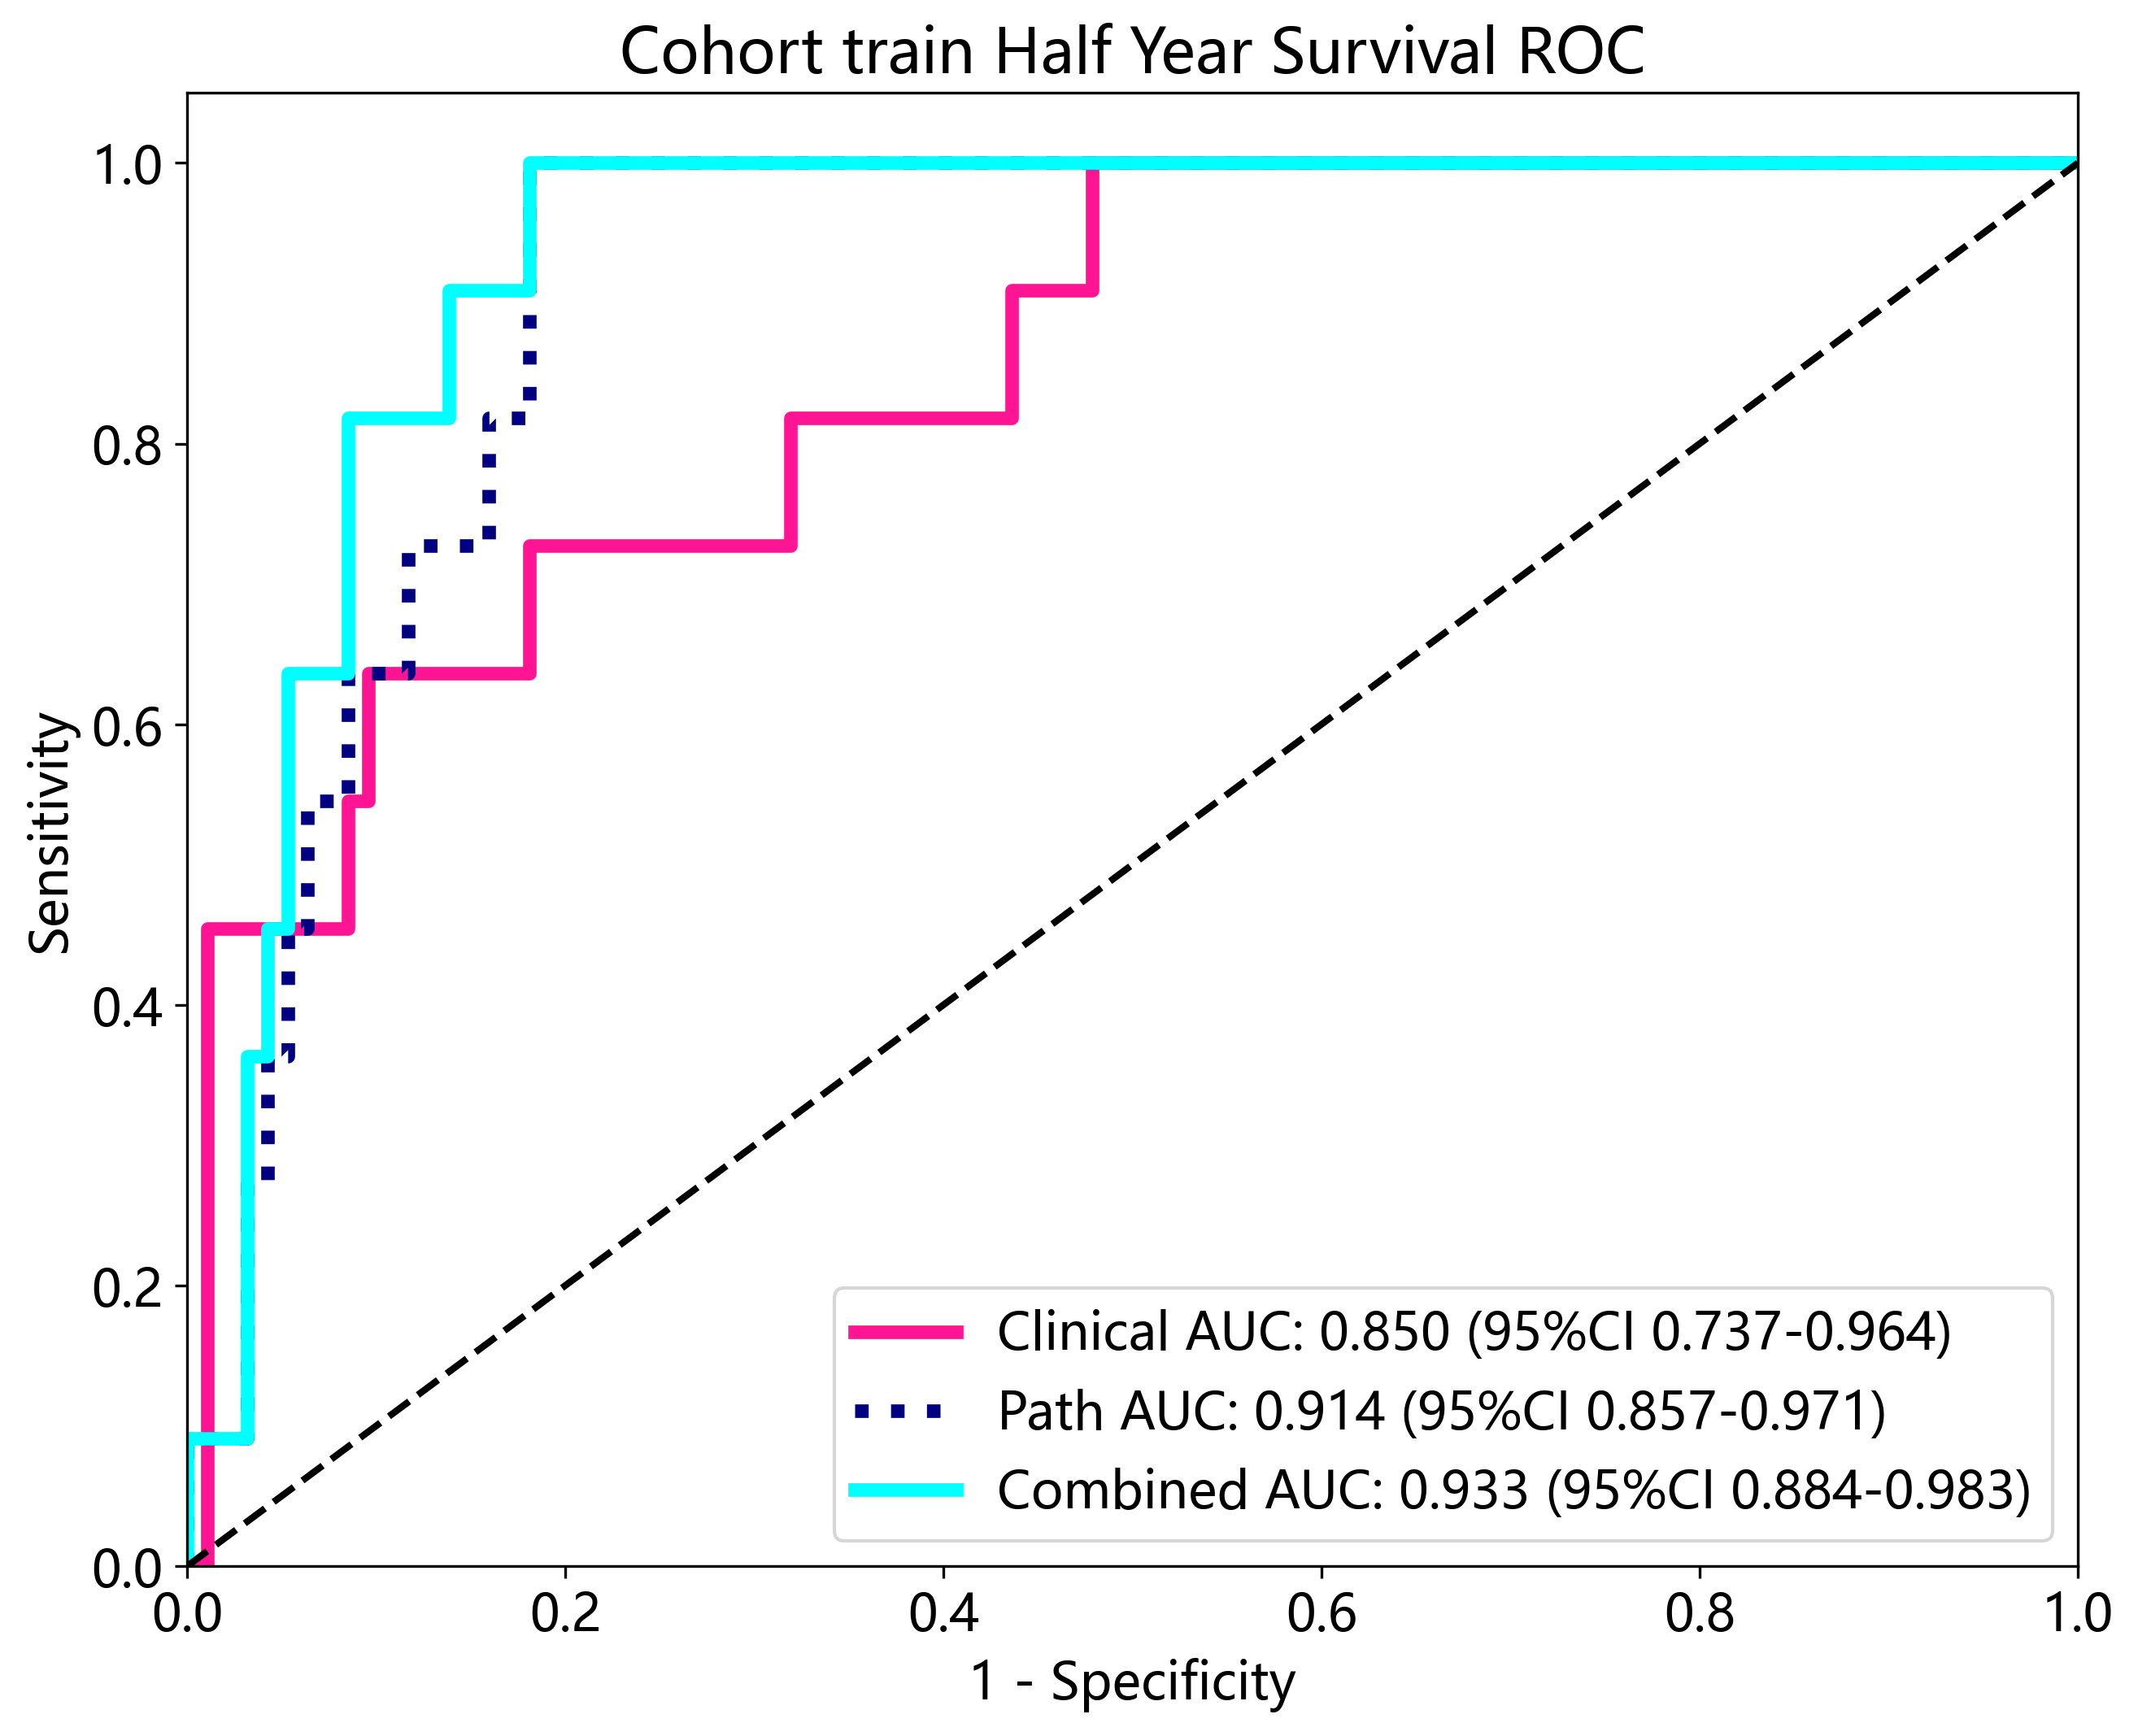

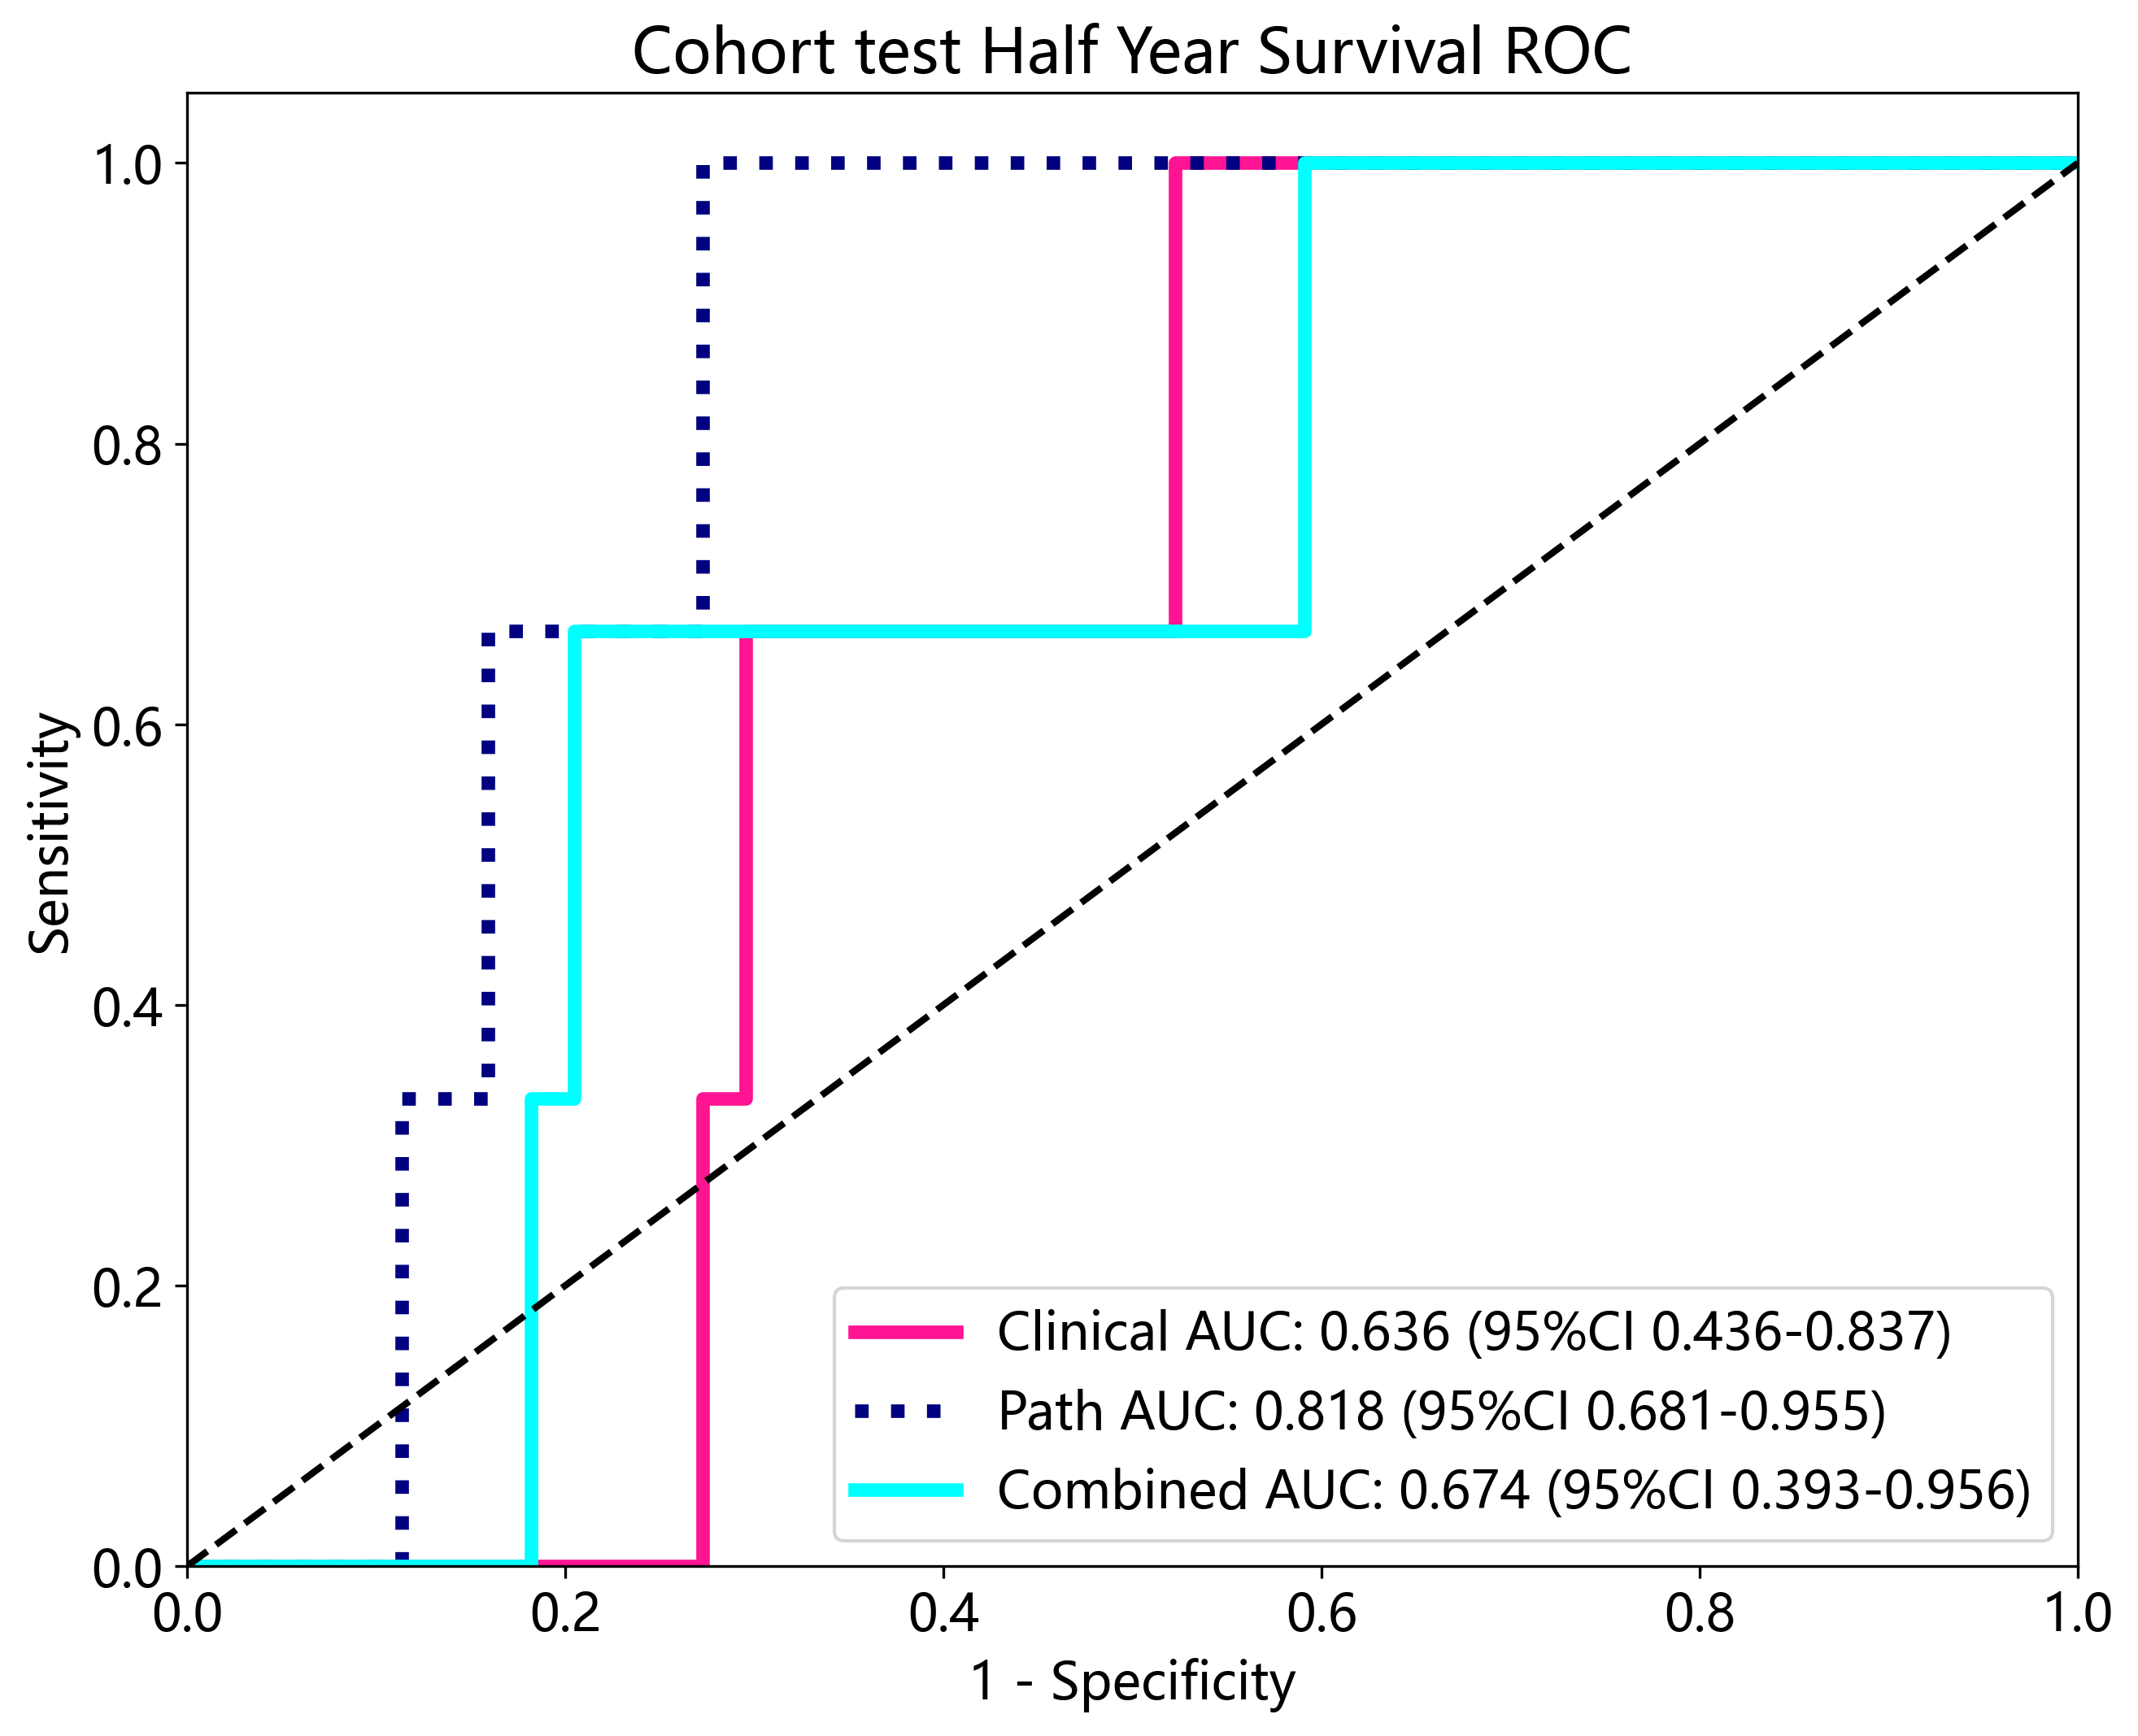

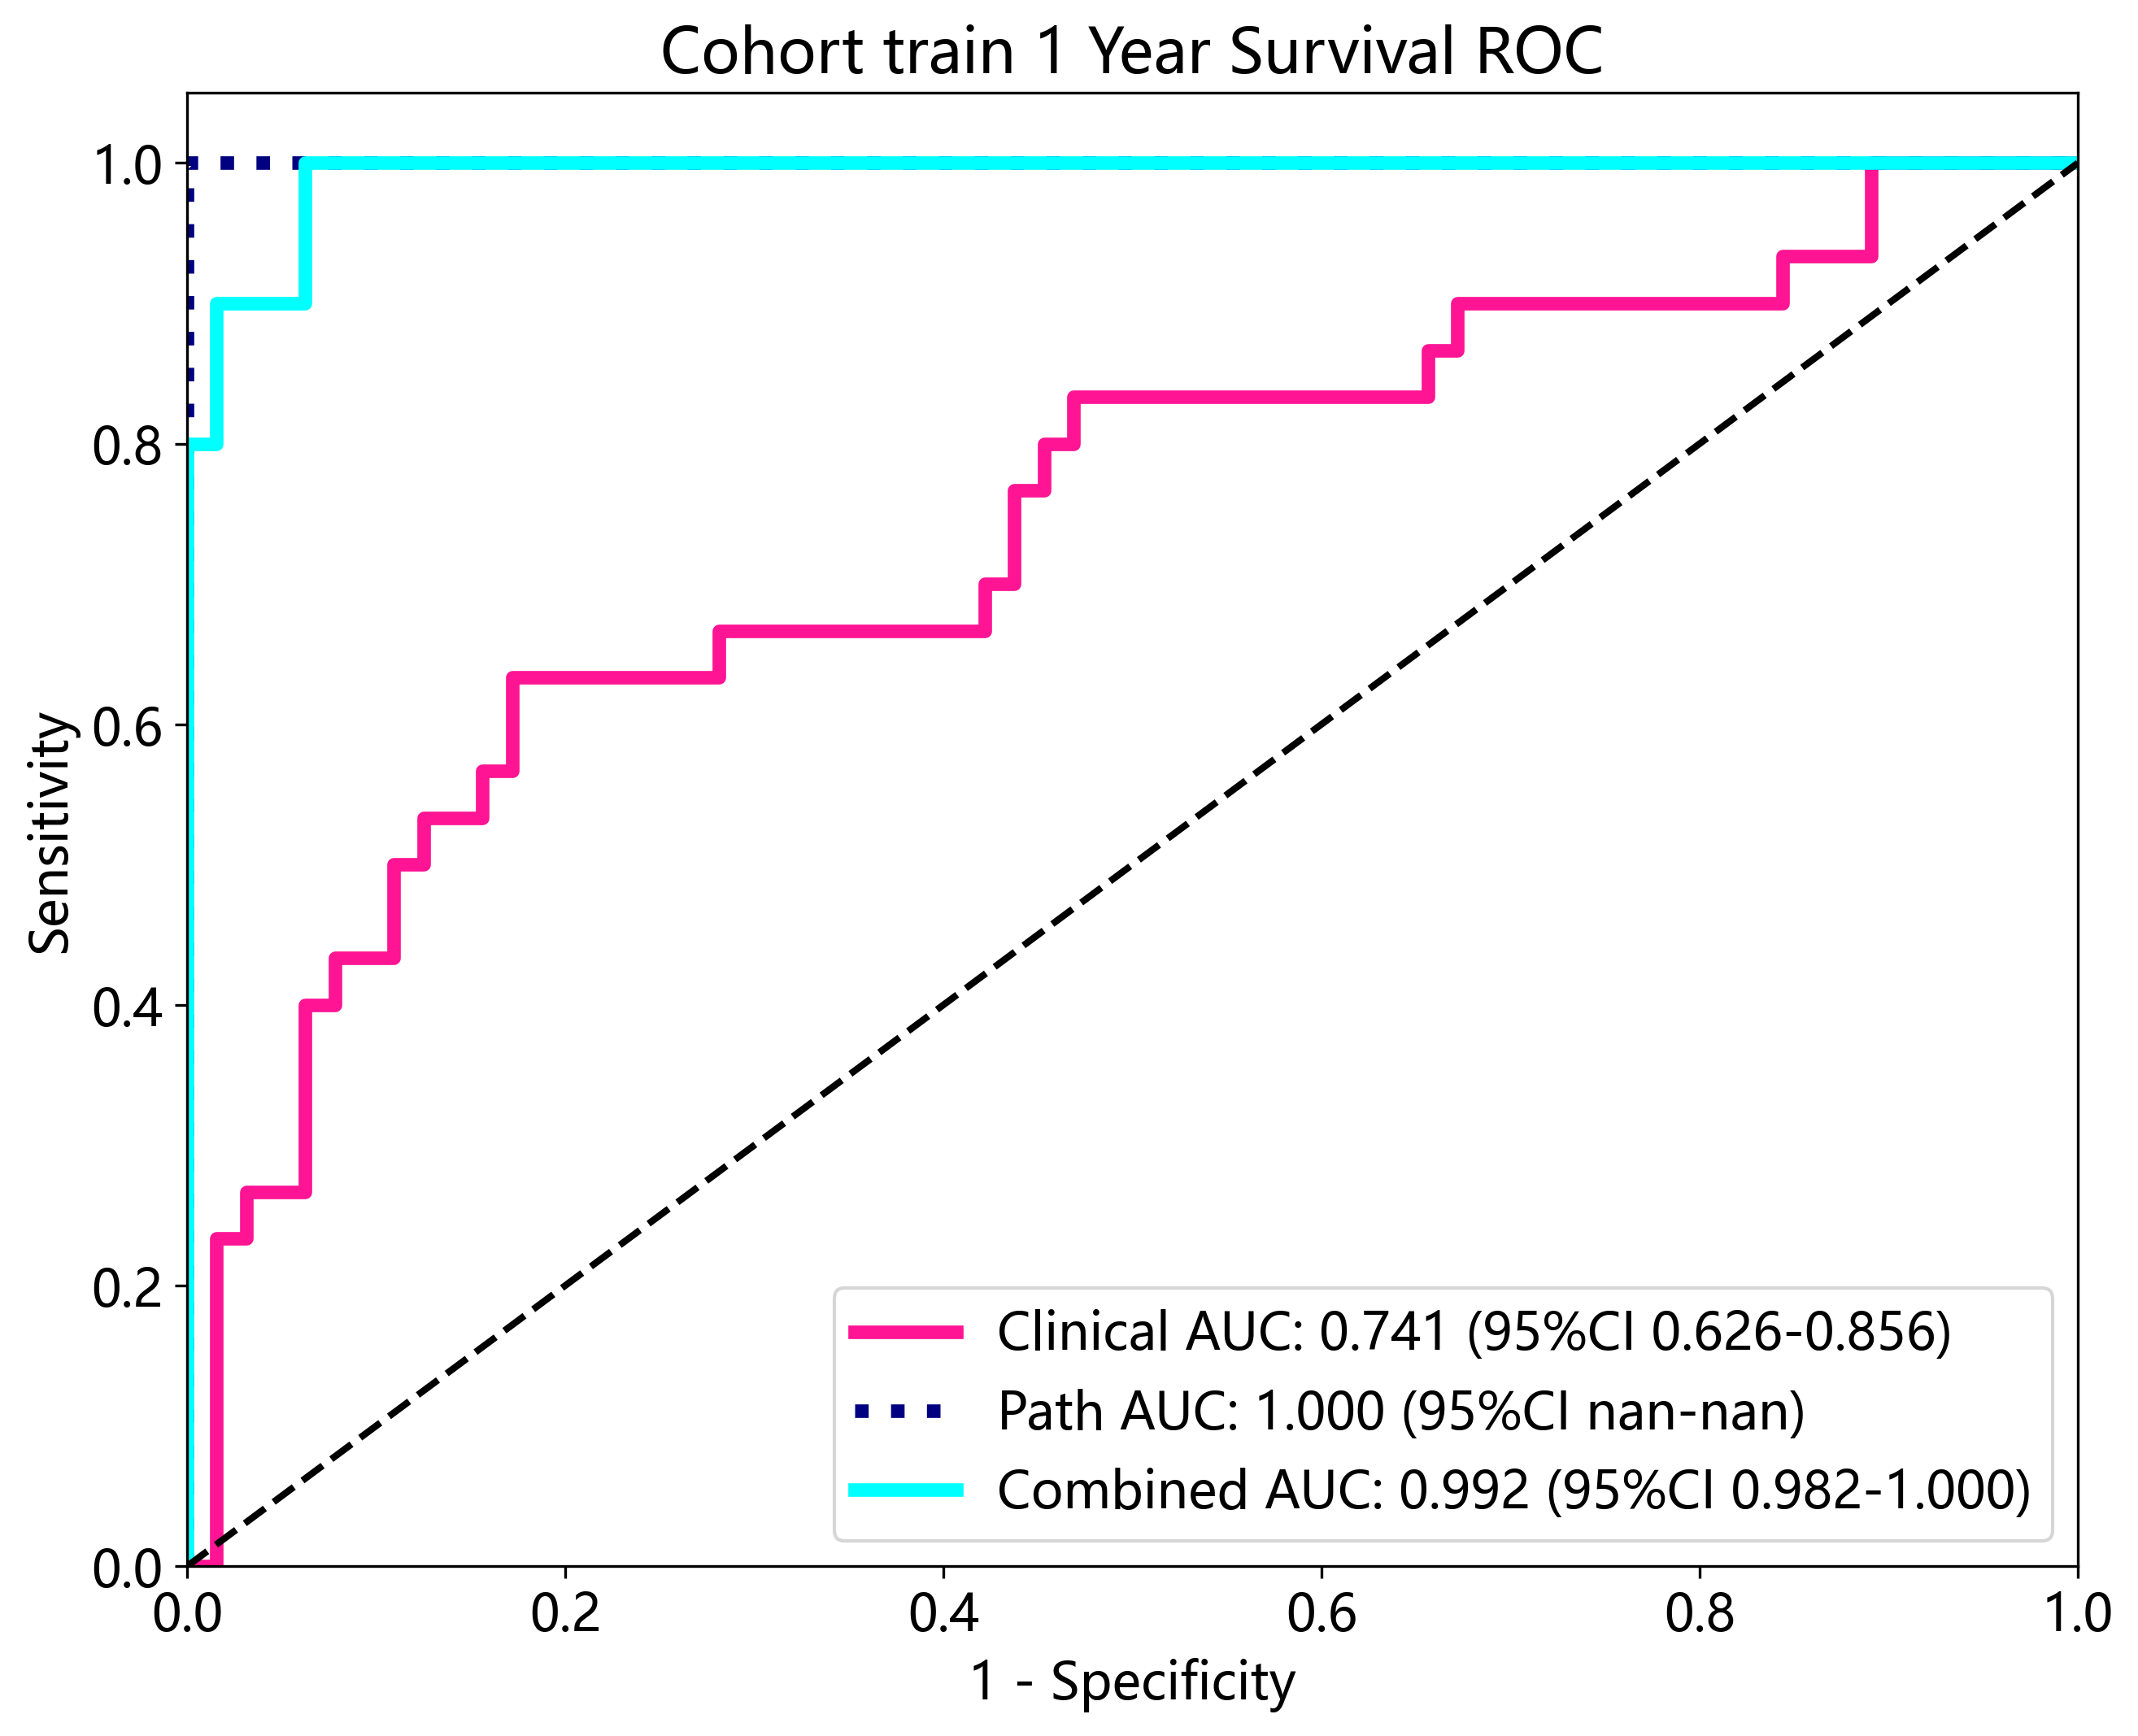

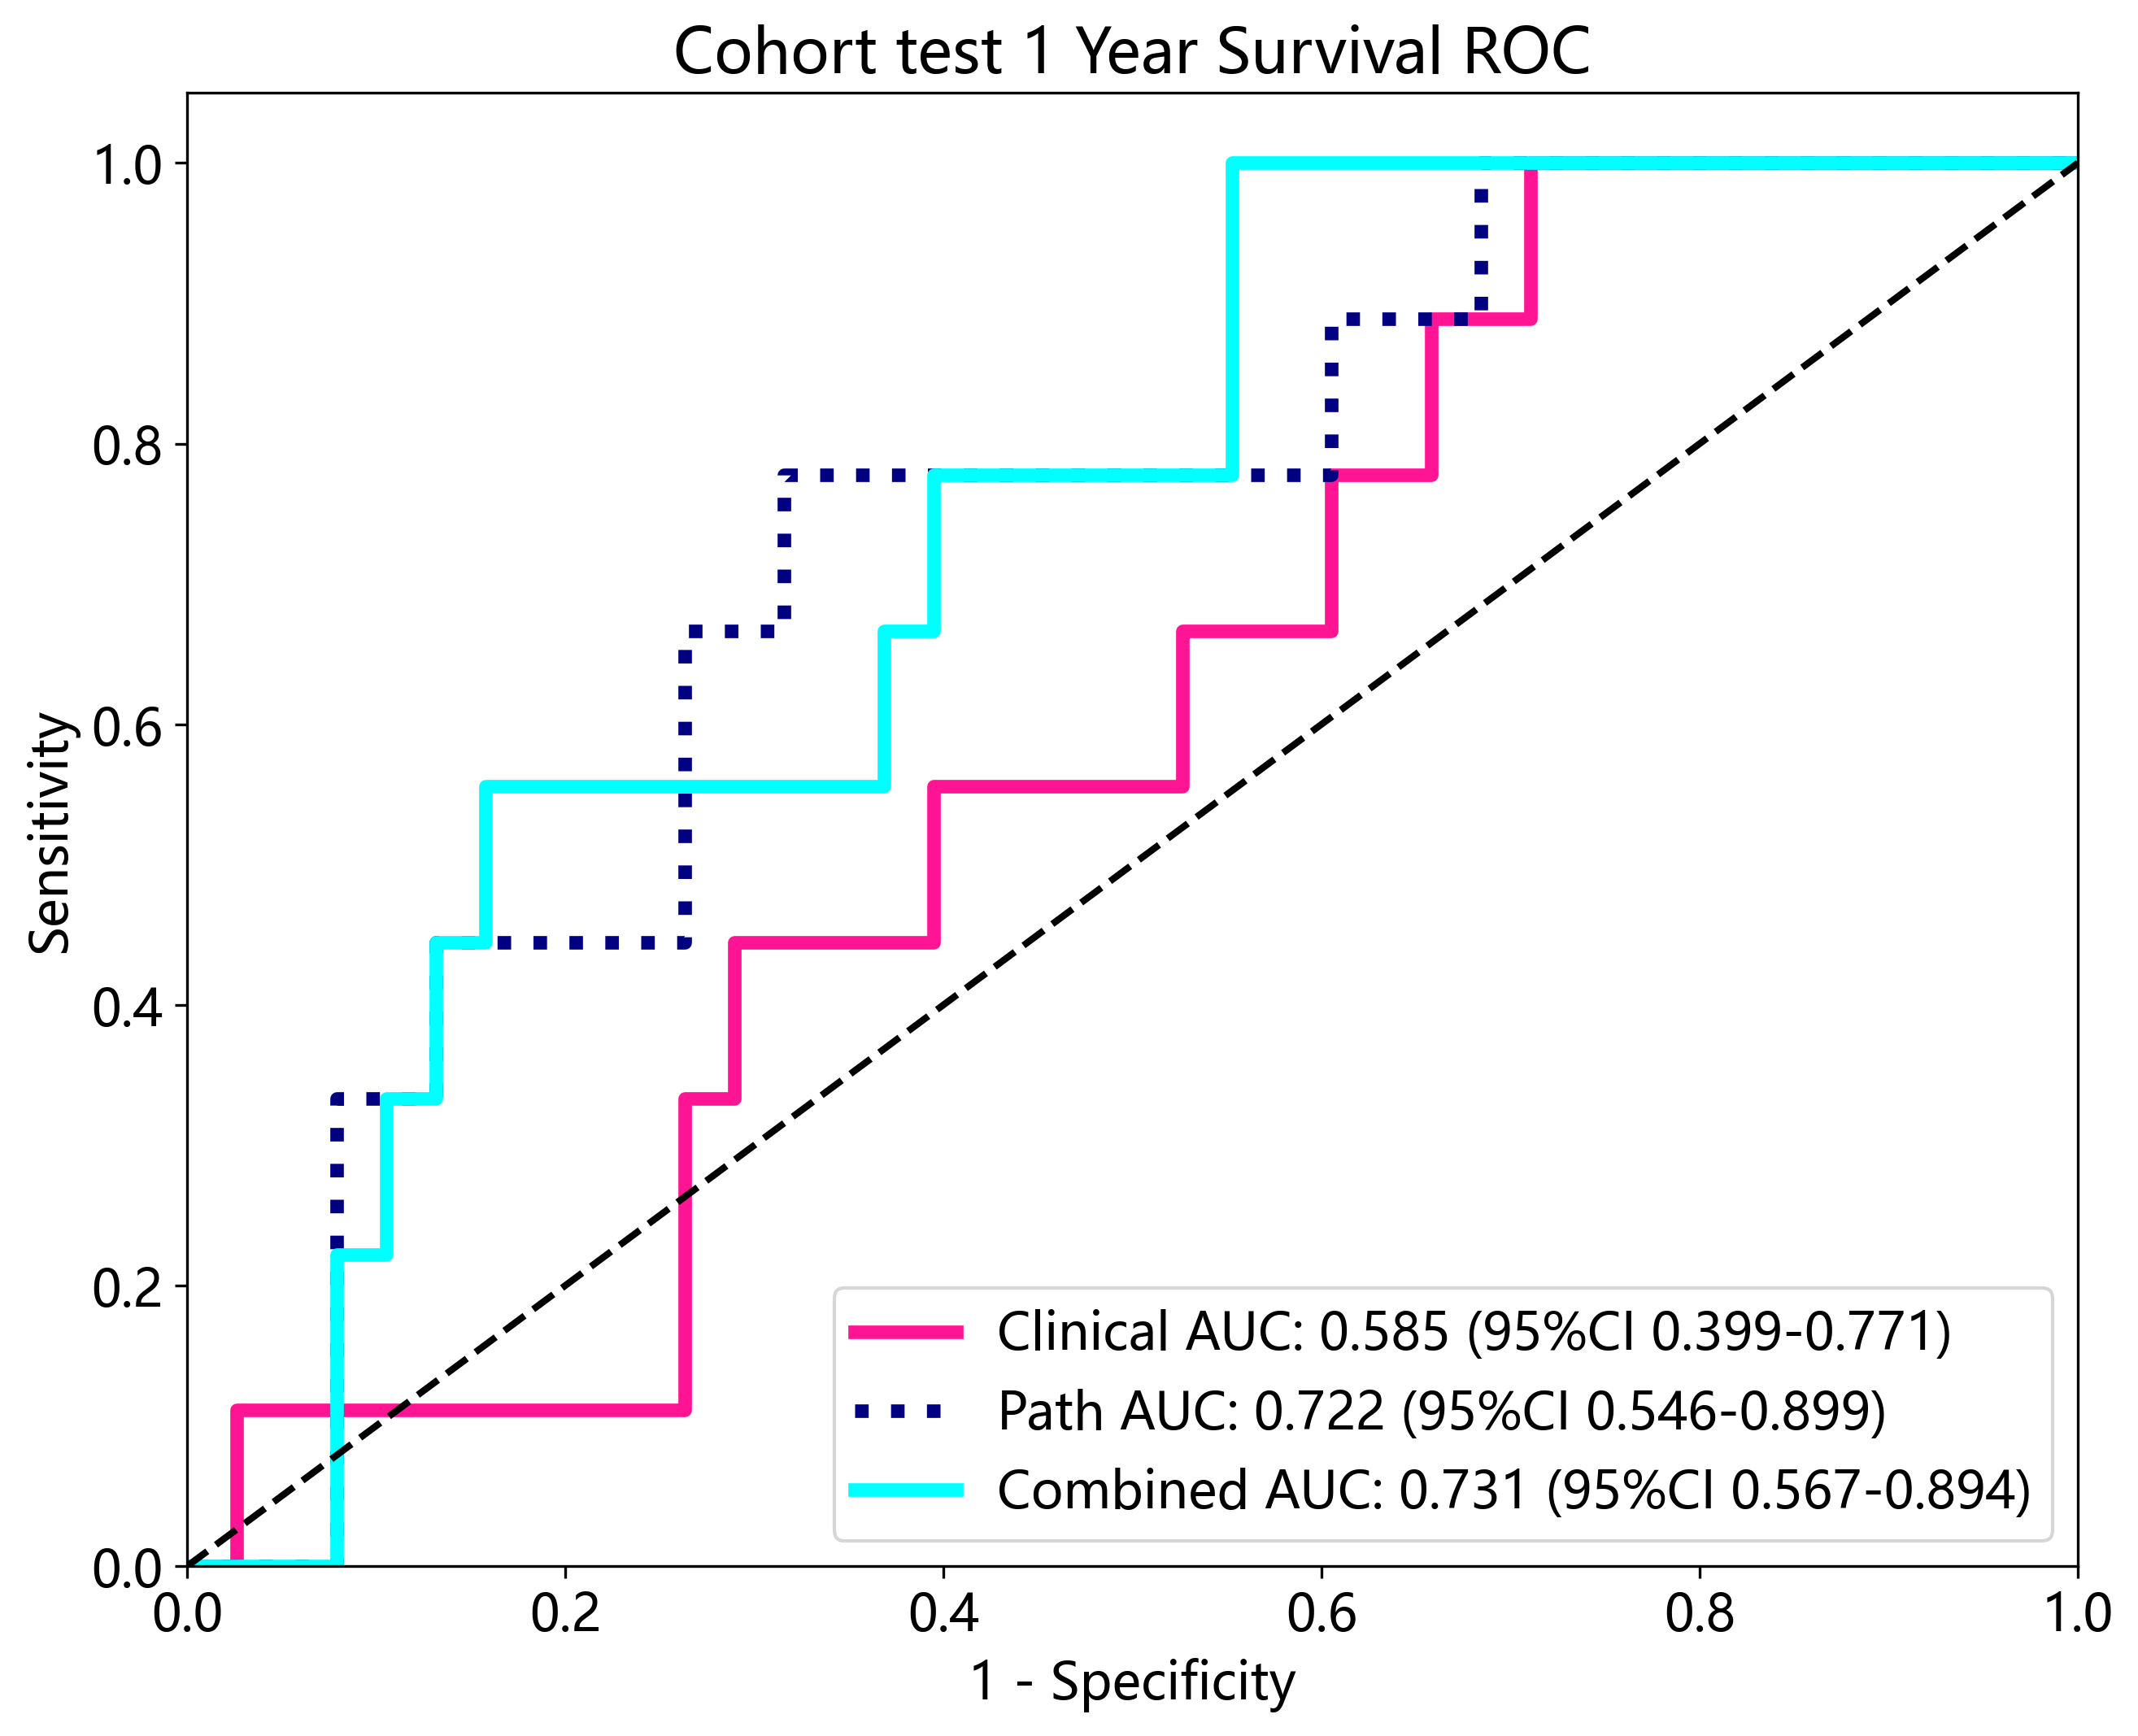

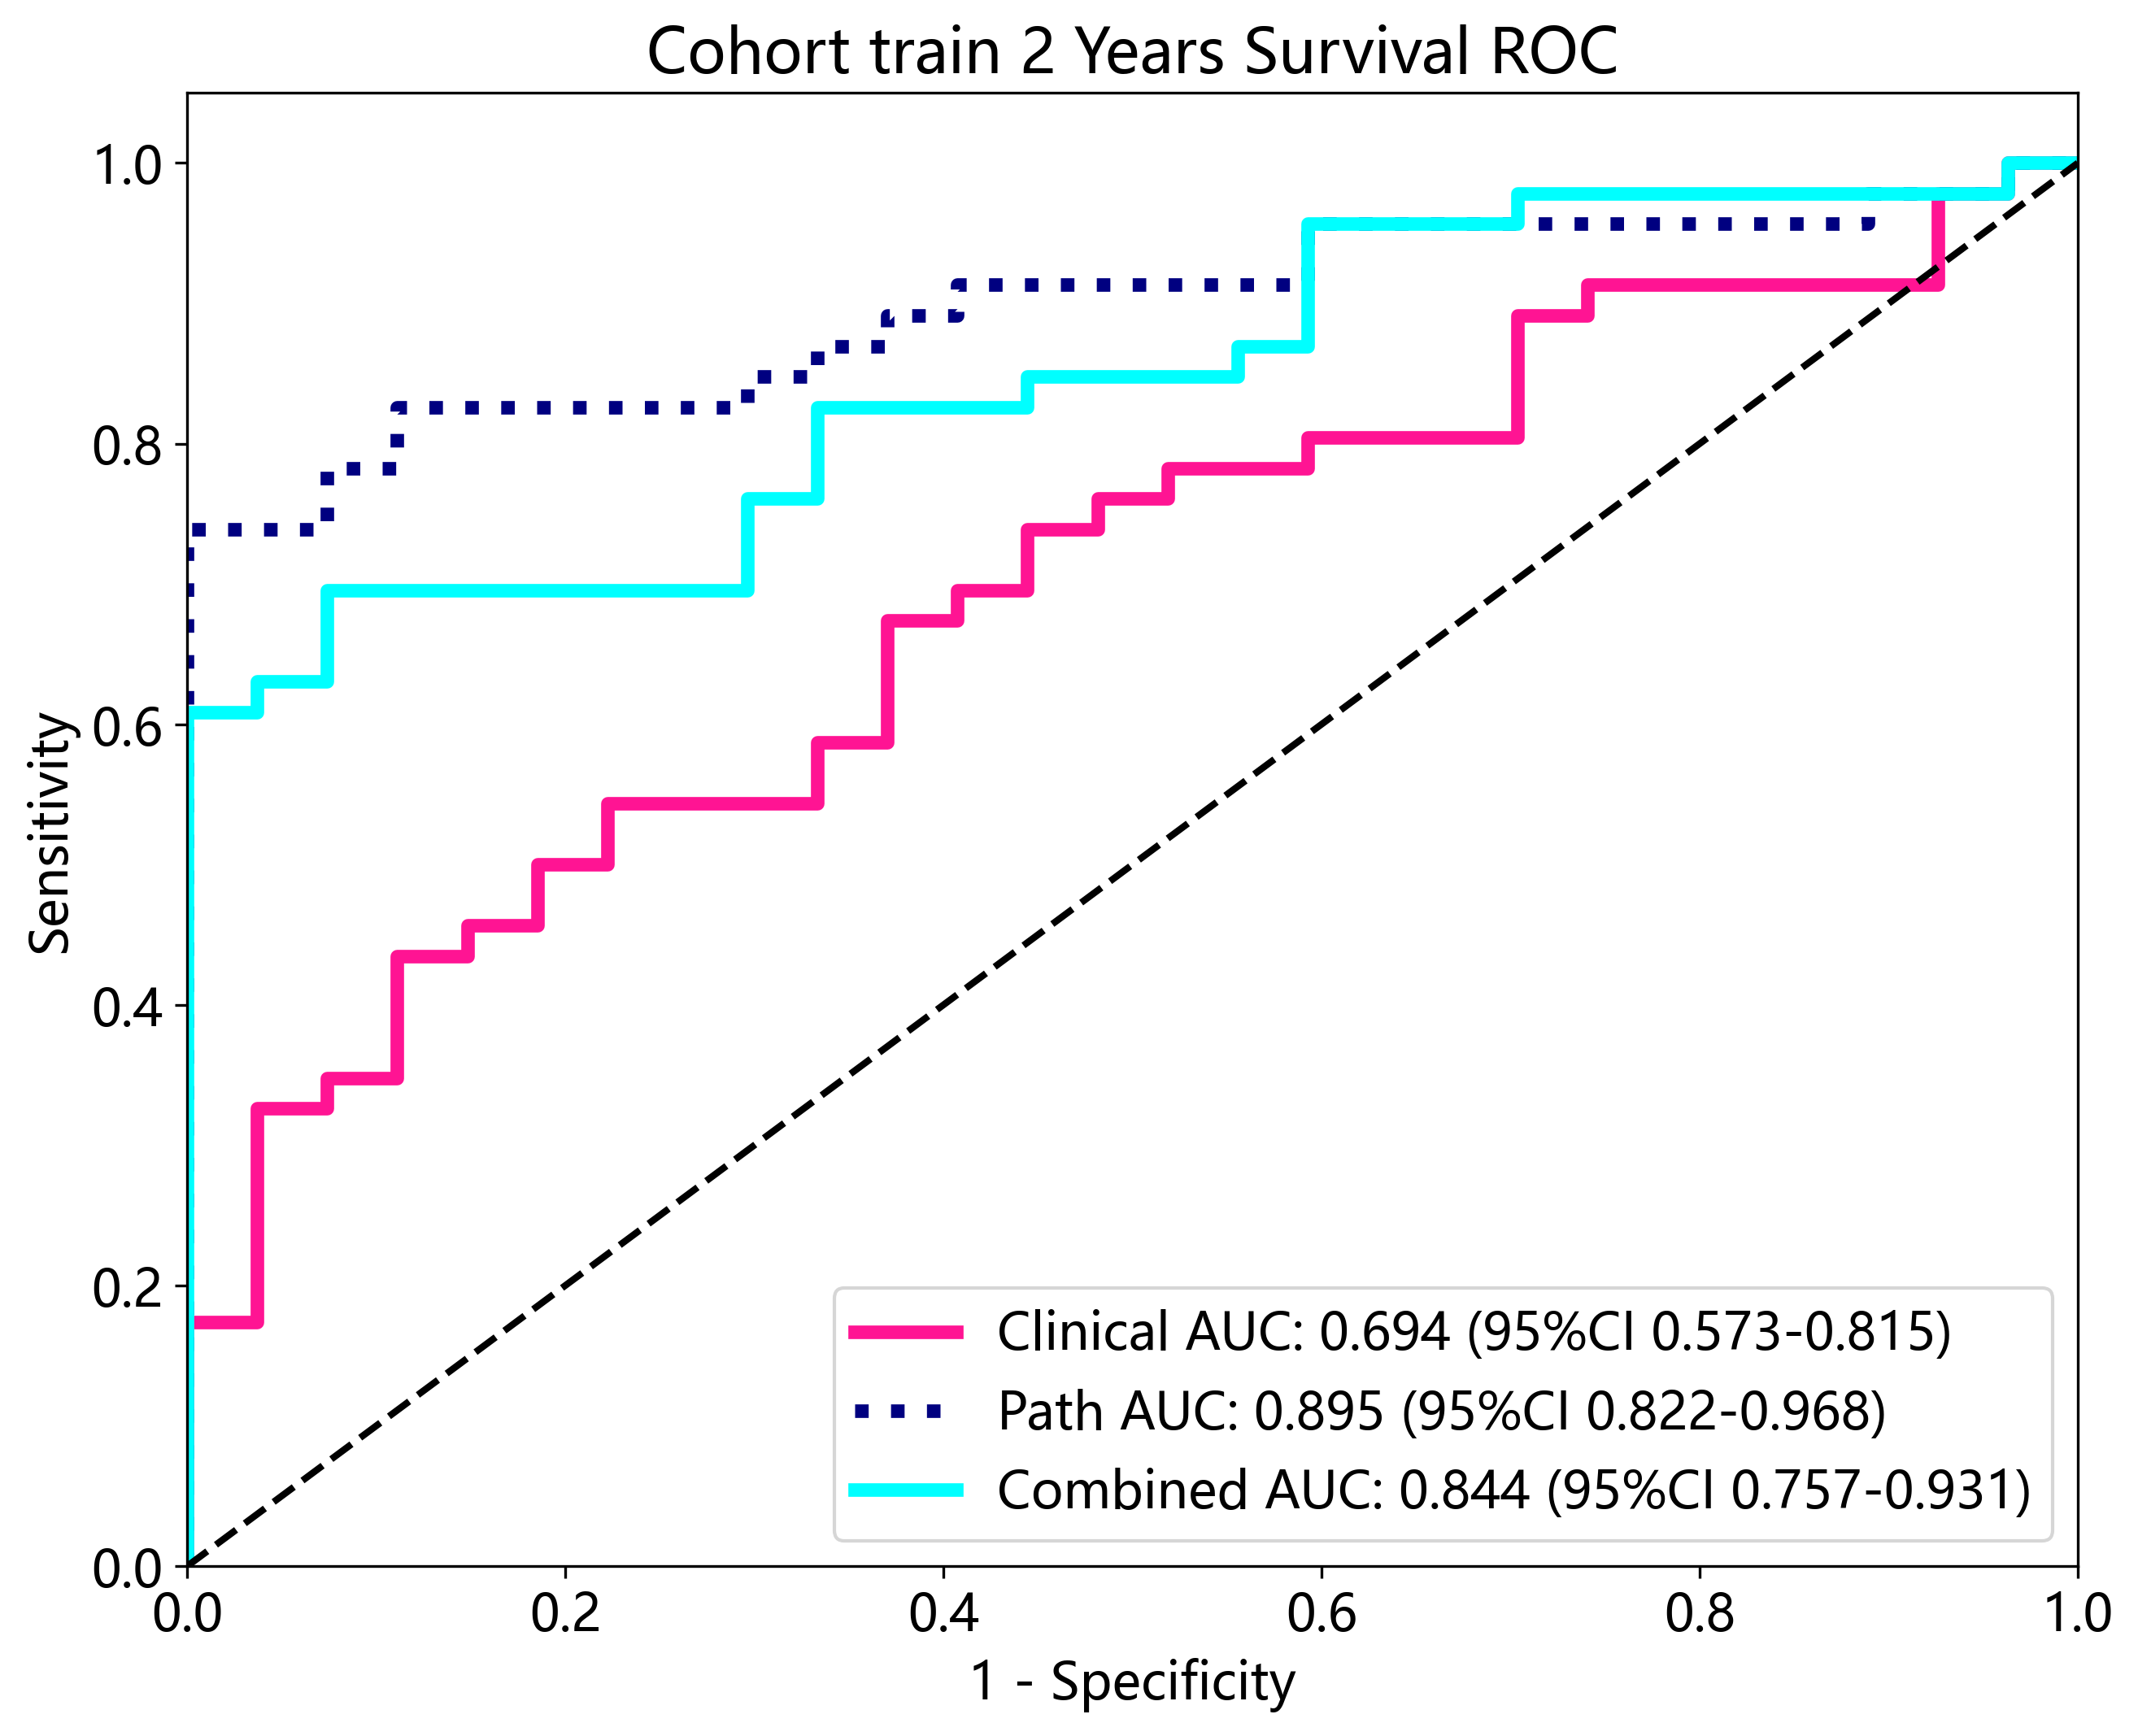

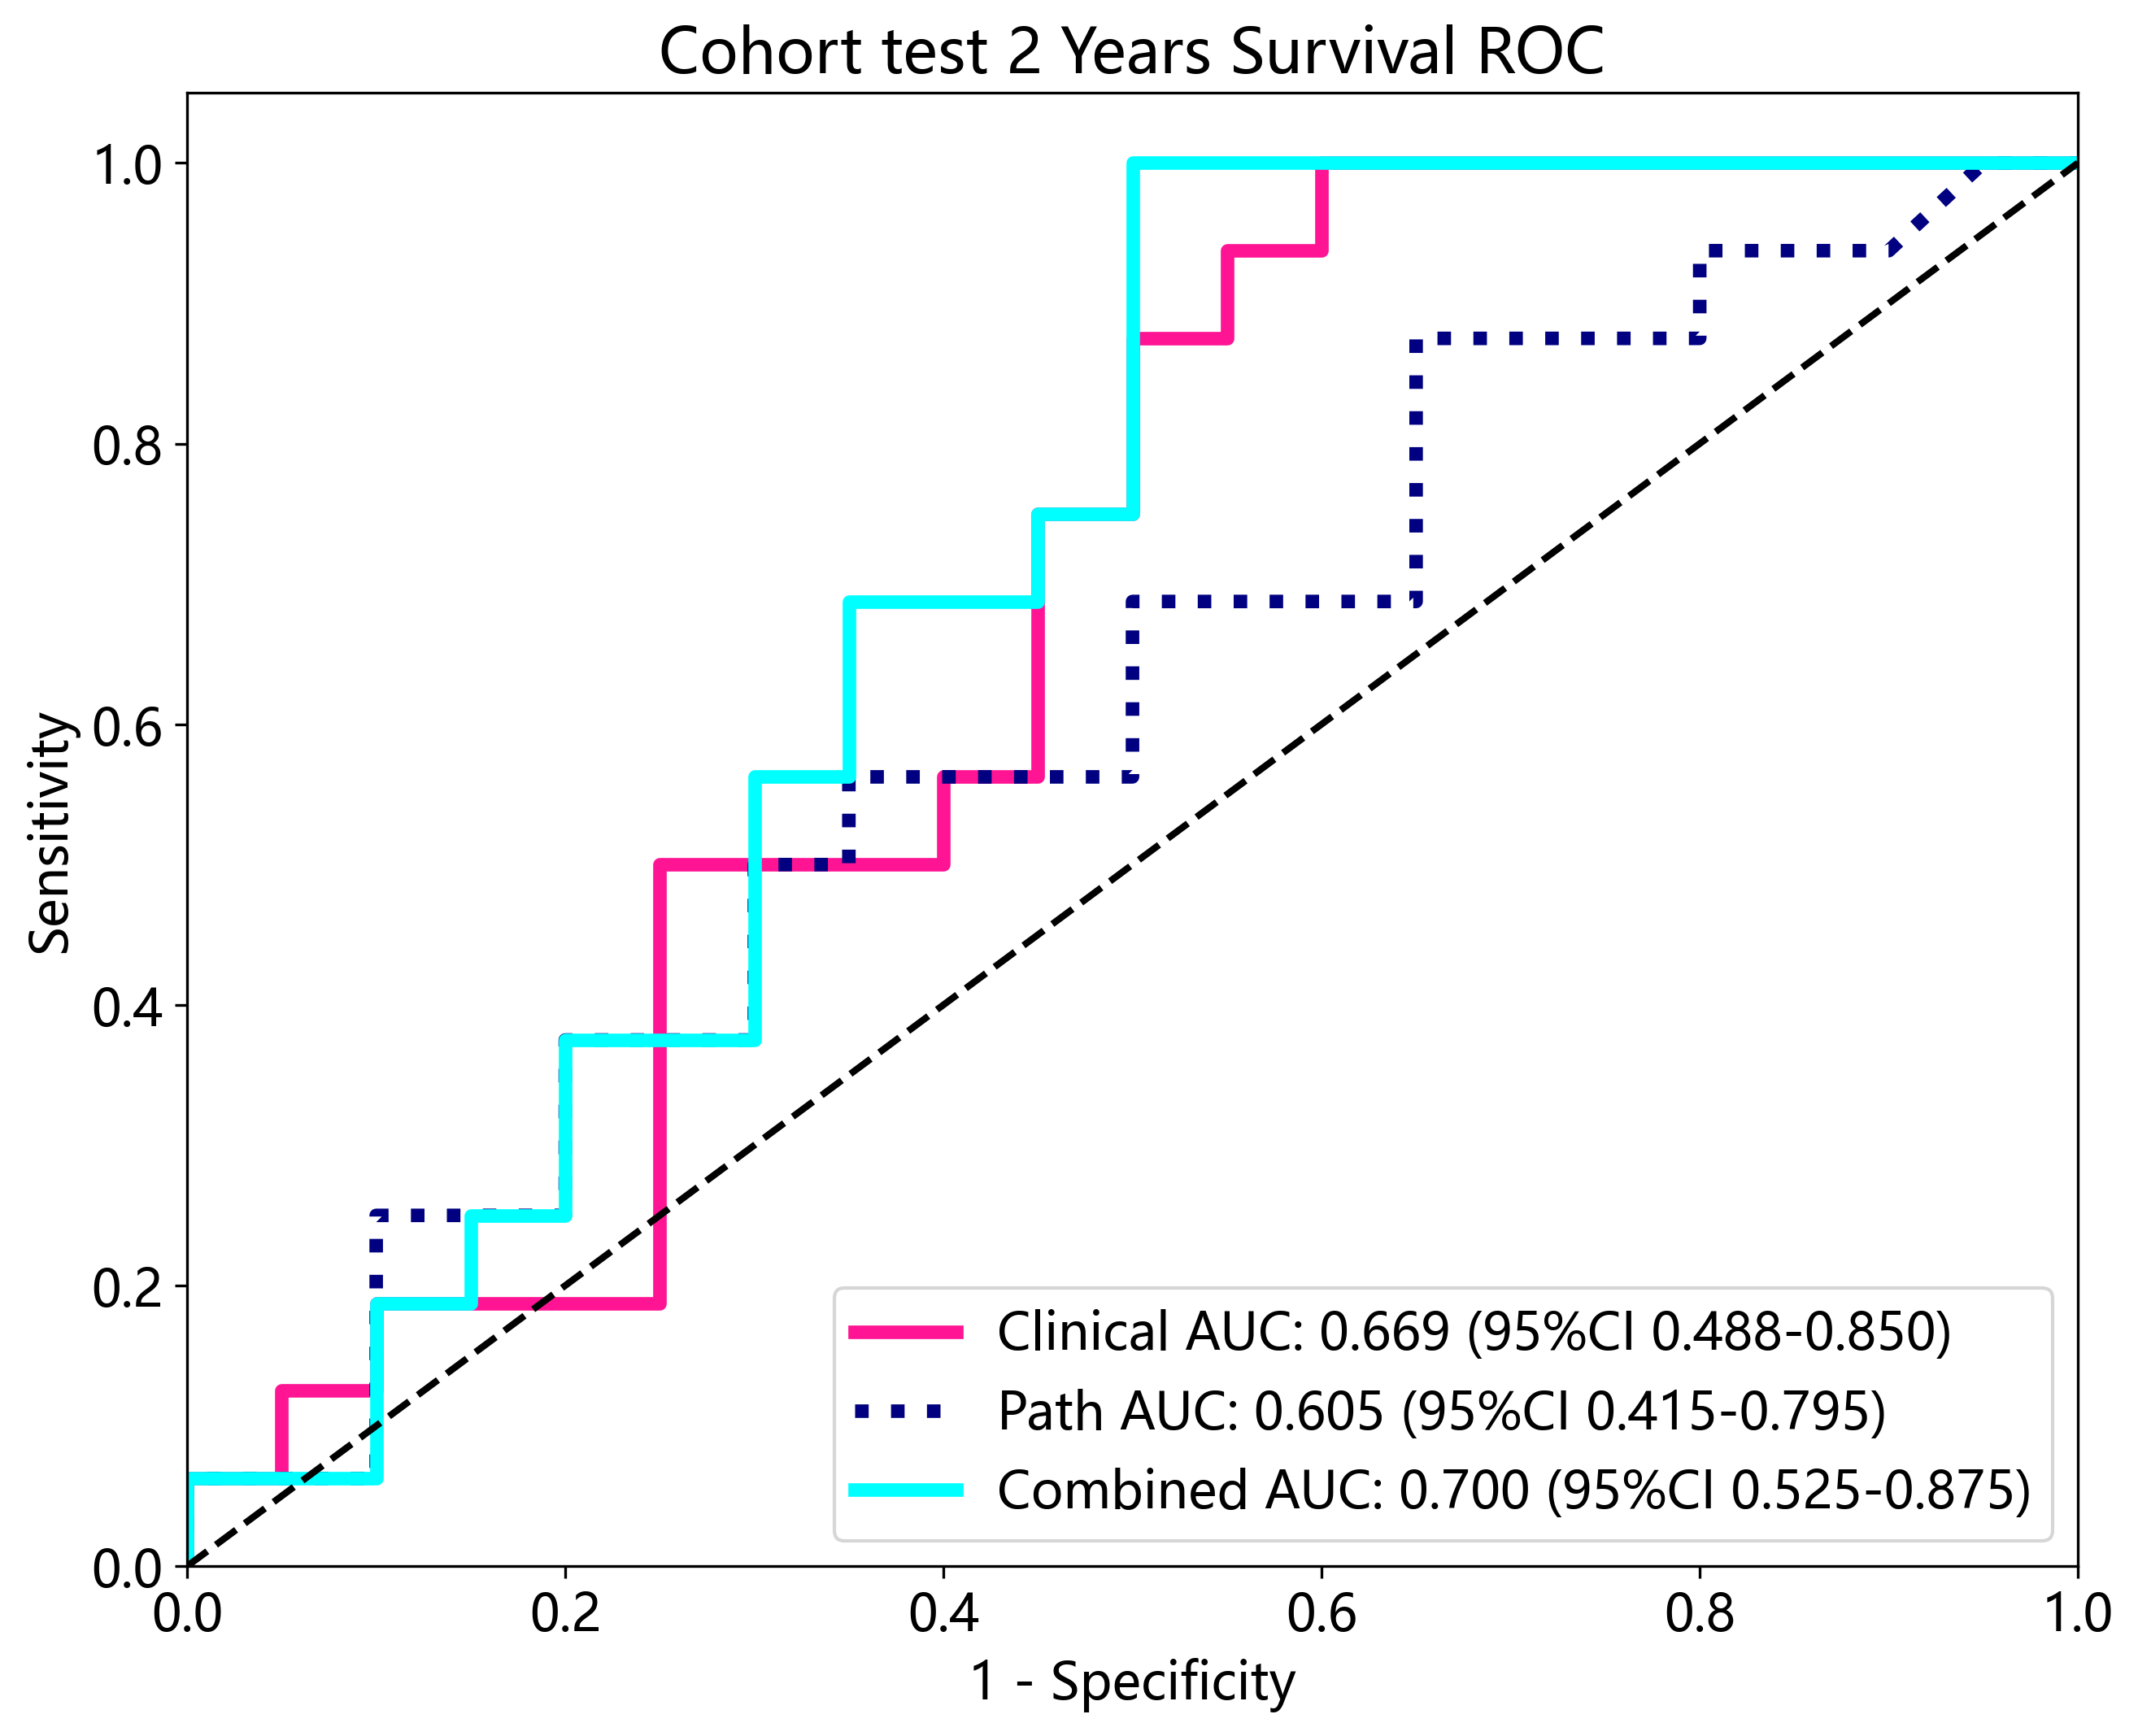

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Survival,Task,Cohort
0,Clinical,0.800,0.850,0.7366 - 0.9636,0.636,0.819,0.292,0.951,Half Year Survival,OS,Train
1,Path,0.829,0.914,0.8567 - 0.9711,0.909,0.819,0.370,0.987,Half Year Survival,OS,Train
2,Combined,0.829,0.933,0.8838 - 0.9828,0.909,0.819,0.370,0.987,Half Year Survival,OS,Train
3,Clinical,0.489,0.636,0.4359 - 0.8368,0.667,0.477,0.080,0.955,Half Year Survival,OS,Test
4,Path,0.723,0.818,0.6813 - 0.9550,0.667,0.727,0.143,0.970,Half Year Survival,OS,Test
5,Combined,0.766,0.674,0.3928 - 0.9556,0.333,0.795,0.100,0.946,Half Year Survival,OS,Test
6,Clinical,0.755,0.741,0.6261 - 0.8562,0.600,0.828,0.621,0.815,1 Year Survival,OS,Train
7,Path,0.989,1.000,1.0000 - 1.0000,0.967,1.000,1.000,0.985,1 Year Survival,OS,Train
8,Combined,0.947,0.992,0.9817 - 1.0000,0.967,0.937,0.879,0.984,1 Year Survival,OS,Train
9,Clinical,0.404,0.585,0.3988 - 0.7708,0.889,0.289,0.229,0.917,1 Year Survival,OS,Test


In [13]:
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import merge_results, draw_roc
from onekey_algo.custom.components.metrics import analysis_pred_binary
metric = []
youden = {}

model_names = ['Clinical', 'Path', 'Combined']

def get_sig(prefix):
    results = [pd.read_csv(f'results/{prefix}_cox_predictions_{subset}.csv')for subset in ['train', 'test']]
    results = pd.concat(results, axis=0)
    return results

for time, tname in [(365*0.5, 'Half Year Survival'), (365*1, '1 Year Survival'), (365*2, '2 Years Survival')]:
    for subset in ['train', 'test']:
        ALL_results = data[['ID', event_col, duration_col, 'group']]
        ALL_results = ALL_results[ALL_results['group'] == subset]
        for sig in model_names:
            signature = get_sig(sig)
            signature.columns = ['ID', sig, 'expectation']
            ALL_results = pd.merge(ALL_results, signature, on='ID', how='inner')

        time_label_data = get_time_dependent_gt(label_data, time=time,  duration_col=duration_col, event_col=event_col)
        ALL_results = pd.merge(ALL_results, time_label_data, on='ID', how='inner')
#         display(ALL_results)
        ALL_results = ALL_results.drop_duplicates('ID')

        gt = [np.array(ALL_results['label']) for _ in model_names]
        pred_train = [np.array(ALL_results[d]) for d in model_names]
        draw_roc(gt, pred_train, labels=model_names, title=f'Cohort {subset} {tname} ROC')
        plt.savefig(f'img/{event_col}_{tname}_{subset}_time_dependent_auc.svg')
        plt.show()
        for mn, y, score in zip(model_names, gt, pred_train):
            # 计算验证集指标
            acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score)
            ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
            metric.append((mn.strip(event_col), acc, auc, ci, tpr, tnr, ppv, npv, tname, event_col, f"{subset[0].upper() + subset[1:]}"))
pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 
                                          'PPV', 'NPV', 'Survival', 'Task', 'Cohort'])